# Inductive bias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import sys 
from importlib import reload
sys.path.append("..//1_Interpolation")
import E1_Functions as func

# Define a discrete color palette with a specified number of colors
#sns.set_palette(sns.color_palette("muted", n_colors=10))  # or use another color map and adjust `n_colors`
custom_palette = ["#FFB347", "#779ECB", "#77DD77", "#FF6961", "#CB99C9", "#FDFD96", "#AEC6CF"]
costum_palette_pairs = ['#ffb347', '#ffcc84', '#ffe6c2', 
                        '#779ecb', '#a4bedc', '#d2dfee', 
                        '#77dd77', '#a4e8a4', '#d2f4d2', 
                        '#ff6961', '#ff9b96', '#ffcdca', 
                        '#cb99c9', '#dcbbdb', '#eedded', 
                        '#fdfd96', '#fefeb9', '#fefedc',
                        '#aec6cf', '#c9d9df', '#e4ecef']

sns.set_palette(custom_palette)
colors = sns.color_palette()
colors_pairs = sns.color_palette(costum_palette_pairs) #("tab20c")

# set title font size
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Enable LaTeX font rendering
#plt.rcParams.update({
#    "text.usetex": True,            # Use LaTeX for all text
#    "font.family": "serif",         # Set the font family to serif (LaTeX default)
#    "font.serif": ["Computer Modern"]  # Use Computer Modern font (LaTeX default font)
#})


In [2]:
save_results = False
save_plots = False

In [3]:
# Helper Function: Analytical solution to the 1D underdamped harmonic oscillator
def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator."""
    assert d < w0, "Damping coefficient must be less than angular frequency for underdamped motion."
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    y = torch.exp(-d * x) * 2 * A * torch.cos(phi + w * x)
    return y

# Updated generate_data function
def generate_data(num_points, noise_std=0.3, n_waves=15, shifted=False, d=0, w0=1):
    # Generate train_x in the specified range
    train_x = np.linspace(-n_waves * np.pi, n_waves * np.pi, num_points)
    train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
    
    # Generate train_y using the oscillator function and add noise
    train_y = oscillator(d, w0, train_x_tensor).numpy() + np.random.normal(0, noise_std, num_points)

    if shifted:  # For shifted test data
        test_x = np.linspace(n_waves * np.pi, 5 * n_waves * np.pi, 100)
    else:        # For non-shifted test data
        test_x = np.linspace(-n_waves * np.pi, n_waves * np.pi, 100)

    test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y = oscillator(d, w0, test_x_tensor).numpy()

    return train_x, train_y, test_x, test_y

# Example

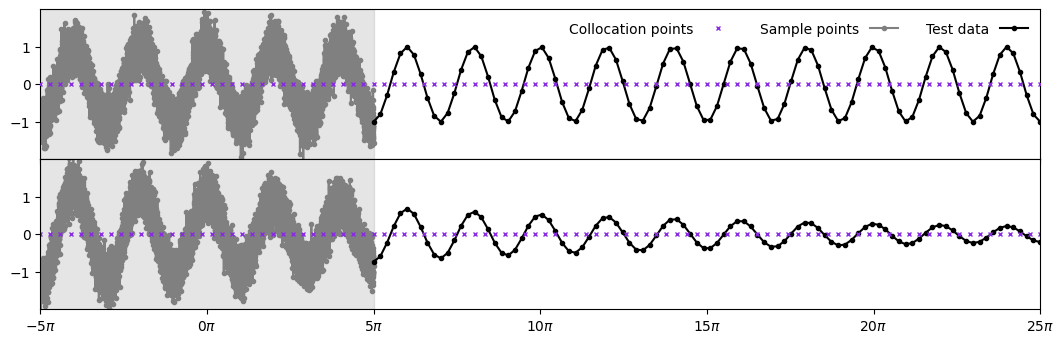

In [4]:
# Parameters for sine wave dataset
noise_std = 0.3
n_waves = 5 #6


fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# HARMOIC OSCILLATOR
N_train_snake = 10000 #4000
N_train_pinn = 9900
N_physics = 100

d, w0 = 0, 1
mu, k = 2*d, w0**2
N_total = 200
N_train = 100
N_physics = 100
N = int(N_total/N_train/2)

# Generate data 
train_x_array_snake_ho, train_y_array_snake_ho, test_x_array_ho, test_y_array_ho = generate_data(N_train_snake, noise_std, n_waves, shifted=True, d=d, w0=w0)
train_x_array_pinn_ho, train_y_array_pinn_ho, _, _ = generate_data(N_train_pinn, noise_std, n_waves, shifted=True, d=d, w0=w0)

# plot analytical solution on top of training data
x = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_train_snake)
x_physics = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_physics).requires_grad_(True)
y = oscillator(d, w0, x)

axes[0].plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Collocation points', color='blueviolet', marker='x', ms=3, ls='', zorder=3)
axes[0].plot(train_x_array_snake_ho, train_y_array_snake_ho, label='Sample points', color='grey', marker='o', ms=3, ls='-')
axes[0].plot(test_x_array_ho, test_y_array_ho, label='Test data', color='black', marker='o', ms=3, ls='-')
#axes[0].plot(x, y, label='Analytical solution', color=colors[1])
axes[0].legend(loc='upper right', frameon=False, markerfirst=False, ncols=3)
axes[0].axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)
axes[0].set_xlim(-5 * np.pi, 25 * np.pi)
axes[0].set_ylim(-2, 2)
axes[0].set_yticks(np.arange(-1, 2, 1))


# DAMPED HARMONIC OSCILLATOR

d = 0.02    # Damping coefficient (must be less than w0)
mu = 2*d

# Generate data for snake
train_x_array_snake_dho, train_y_array_snake_dho, test_x_array_dho, test_y_array_dho = generate_data(N_train_snake, noise_std, n_waves, shifted=True, d=d, w0=w0)
train_x_array_pinn_dho, train_y_array_pinn_dho, _, _ = generate_data(N_train_pinn, noise_std, n_waves, shifted=True, d=d, w0=w0)

# plot analytical solution on top of training data
x = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_train_snake)
x_physics = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_physics).requires_grad_(True)
y = oscillator(d, w0, x)


axes[1].plot(train_x_array_snake_dho, train_y_array_snake_dho, label='Train data', color='grey', marker='o', ms=3, ls='-')
axes[1].plot(test_x_array_dho, test_y_array_dho, label='Test data', color='black', marker='o', ms=3, ls='-')
#axes[1].plot(x, y, label='Analytical solution', color=colors[1])
axes[1].plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Physics loss training locations', color='blueviolet', marker='x', ms=3, ls='')
axes[1].set_ylim(-2, 2)
axes[1].axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)
axes[1].set_xticks(np.arange(-5, 26, 5)*np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])
axes[1].set_yticks(np.arange(-1, 2, 1))

plt.subplots_adjust(hspace=0, wspace=0) # Remove all spaces between subplots
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
plt.show()

# Results: Harmonic Osciilator

In [68]:
# load data
HO_train_pred_ReLU = np.load('E2_Results/HO_ReLU_train_pred.npy')
HO_test_pred_ReLU = np.load('E2_Results/HO_ReLU_test_pred.npy')
HO_train_pred_tanh = np.load('E2_Results/HO_tanh_train_pred.npy')
HO_test_pred_tanh = np.load('E2_Results/HO_tanh_test_pred.npy')
HO_train_pred_sine = np.load('E2_Results/HO_sine_train_pred.npy')
HO_test_pred_sine = np.load('E2_Results/HO_sine_test_pred.npy')
HO_train_pred_snake = np.load('E2_Results/HO_snake_train_pred.npy')
HO_test_pred_snake = np.load('E2_Results/HO_snake_test_pred.npy')
HO_train_pred_pinn = np.load('E2_Results/HO_pinn_train_pred.npy')
HO_test_pred_pinn = np.load('E2_Results/HO_pinn_test_pred.npy')

In [69]:
mean = pd.DataFrame(columns=['ReLU', 'Tanh', 'Sine', 'Snake', 'PINN'], index=['Train', 'Test'])
std = pd.DataFrame(columns=['ReLU', 'Tanh', 'Sine', 'Snake', 'PINN'], index=['Train', 'Test'])

mean.loc['Train', 'ReLU'] = np.mean(HO_train_pred_ReLU, axis=0)
mean.loc['Test', 'ReLU'] = np.mean(HO_test_pred_ReLU, axis=0)

mean.loc['Train', 'Tanh'] = np.mean(HO_train_pred_tanh, axis=0)
mean.loc['Test', 'Tanh'] = np.mean(HO_test_pred_tanh, axis=0)

mean.loc['Train', 'Sine'] = np.mean(HO_train_pred_sine, axis=0)
mean.loc['Test', 'Sine'] = np.mean(HO_test_pred_sine, axis=0)

mean.loc['Train', 'Snake'] = np.mean(HO_train_pred_snake, axis=0)
mean.loc['Test', 'Snake'] = np.mean(HO_test_pred_snake, axis=0)

mean.loc['Train', 'PINN'] = np.mean(HO_train_pred_pinn, axis=0).squeeze()
mean.loc['Test', 'PINN'] = np.mean(HO_test_pred_pinn, axis=0).squeeze()

std.loc['Train', 'ReLU'] = np.std(HO_train_pred_ReLU, axis=0)
std.loc['Test', 'ReLU'] = np.std(HO_test_pred_ReLU, axis=0)

std.loc['Train', 'Tanh'] = np.std(HO_train_pred_tanh, axis=0)
std.loc['Test', 'Tanh'] = np.std(HO_test_pred_tanh, axis=0)

std.loc['Train', 'Sine'] = np.std(HO_train_pred_sine, axis=0)
std.loc['Test', 'Sine'] = np.std(HO_test_pred_sine, axis=0)

std.loc['Train', 'Snake'] = np.std(HO_train_pred_snake, axis=0)
std.loc['Test', 'Snake'] = np.std(HO_test_pred_snake, axis=0)

std.loc['Train', 'PINN'] = np.std(HO_train_pred_pinn, axis=0).squeeze()
std.loc['Test', 'PINN'] = np.std(HO_test_pred_pinn, axis=0).squeeze()


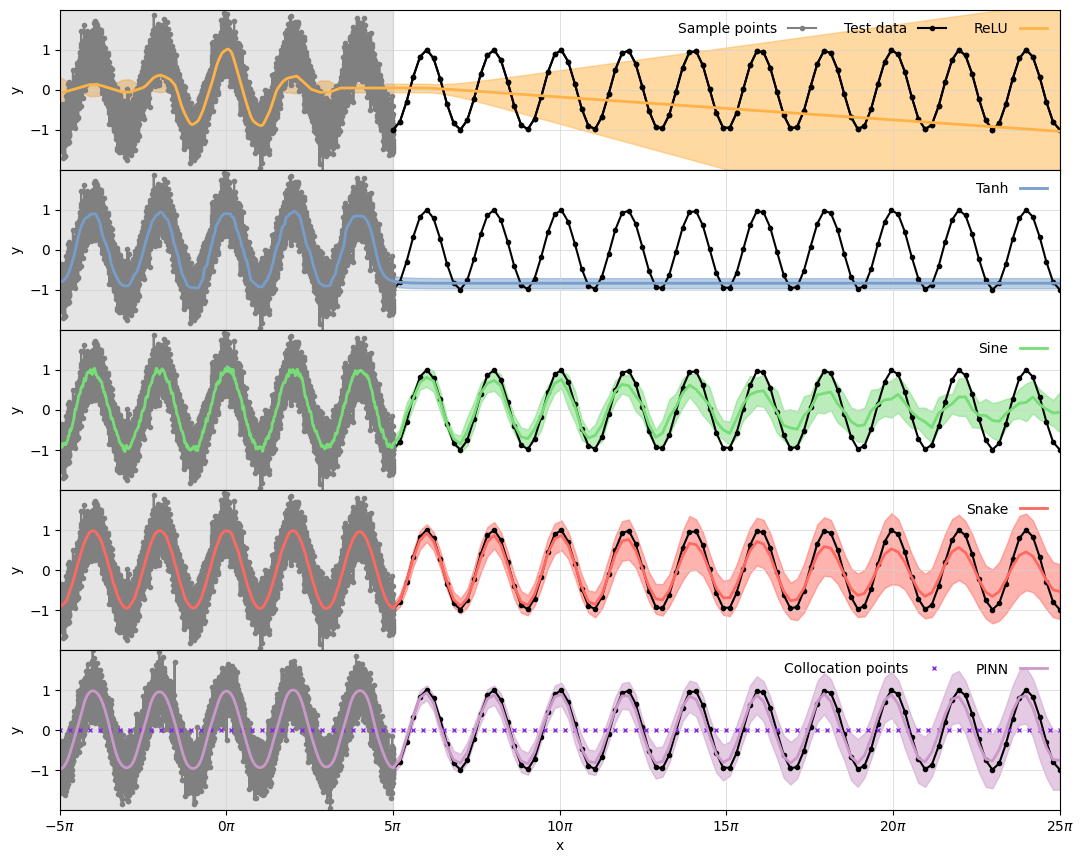

In [70]:
# PLOT RESULTS
# Create a figure and specify GridSpec
fig, axes = plt.subplots(5, 1, figsize=(10, 8), sharex=True) #, gridspec_kw={'height_ratios': [2, 1]})

axes[0].plot(train_x_array_snake_ho, train_y_array_snake_ho, label='Sample points', color='grey', marker='o', ms=3, ls='-')
axes[0].plot(test_x_array_ho, test_y_array_ho, label='Test data', color='black', marker='o', ms=3, ls='-')

# only first four axes
for ax in axes:
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.plot(test_x_array_ho, test_y_array_ho, color='black', marker='o', ms=3, ls='-')

for ax in axes[1:4]:
    ax.plot(train_x_array_snake_ho, train_y_array_snake_ho, color='grey', marker='o', ms=3, ls='-')

lw = 2
alpha = 0.5

axes[0].plot(train_x_array_snake_ho, mean.loc['Train', 'ReLU'], label='ReLU', color=colors[0], lw=lw)
axes[0].fill_between(train_x_array_snake_ho, mean.loc['Train', 'ReLU'] - std.loc['Train', 'ReLU'], mean.loc['Train', 'ReLU'] + std.loc['Train', 'ReLU'], color=colors[0], alpha=alpha) 
axes[0].plot(test_x_array_ho, mean.loc['Test', 'ReLU'], color=colors[0], ls='-', lw=lw)
axes[0].fill_between(test_x_array_ho, mean.loc['Test', 'ReLU'] - std.loc['Test', 'ReLU'], mean.loc['Test', 'ReLU'] + std.loc['Test', 'ReLU'], color=colors[0], alpha=alpha)

axes[1].plot(train_x_array_snake_ho, mean.loc['Train', 'Tanh'], label='Tanh', color=colors[1], lw=lw)
axes[1].fill_between(train_x_array_snake_ho, mean.loc['Train', 'Tanh'] - std.loc['Train', 'Tanh'], mean.loc['Train', 'Tanh'] + std.loc['Train', 'Tanh'], color=colors[1], alpha=alpha)
axes[1].plot(test_x_array_ho, mean.loc['Test', 'Tanh'], color=colors[1], ls='-', lw=lw)
axes[1].fill_between(test_x_array_ho, mean.loc['Test', 'Tanh'] - std.loc['Test', 'Tanh'], mean.loc['Test', 'Tanh'] + std.loc['Test', 'Tanh'], color=colors[1], alpha=alpha)

axes[2].plot(train_x_array_snake_ho, mean.loc['Train', 'Sine'], label='Sine', color=colors[2], lw=lw)
axes[2].fill_between(train_x_array_snake_ho, mean.loc['Train', 'Sine'] - std.loc['Train', 'Sine'], mean.loc['Train', 'Sine'] + std.loc['Train', 'Sine'], color=colors[2], alpha=alpha)
axes[2].plot(test_x_array_ho, mean.loc['Test', 'Sine'], color=colors[2], ls='-', lw=lw)
axes[2].fill_between(test_x_array_ho, mean.loc['Test', 'Sine'] - std.loc['Test', 'Sine'], mean.loc['Test', 'Sine'] + std.loc['Test', 'Sine'], color=colors[2], alpha=alpha)

axes[3].plot(train_x_array_snake_ho, mean.loc['Train', 'Snake'], label='Snake', color=colors[3], lw=lw)
axes[3].fill_between(train_x_array_snake_ho, mean.loc['Train', 'Snake'] - std.loc['Train', 'Snake'], mean.loc['Train', 'Snake'] + std.loc['Train', 'Snake'], color=colors[3], alpha=alpha)
axes[3].plot(test_x_array_ho, mean.loc['Test', 'Snake'], color=colors[3], ls='-', lw=lw)
axes[3].fill_between(test_x_array_ho, mean.loc['Test', 'Snake'] - std.loc['Test', 'Snake'], mean.loc['Test', 'Snake'] + std.loc['Test', 'Snake'], color=colors[3], alpha=alpha)

axes[4].plot(train_x_array_pinn_ho, train_y_array_pinn_ho, color='grey', marker='o', ms=3, ls='-')
axes[4].plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Collocation points', color='blueviolet', marker='x', ms=3, ls='')
axes[4].plot(train_x_array_pinn_ho, mean.loc['Train', 'PINN'], label='PINN', color=colors[4], lw=lw)
axes[4].fill_between(train_x_array_pinn_ho, mean.loc['Train', 'PINN'] - std.loc['Train', 'PINN'], mean.loc['Train', 'PINN'] + std.loc['Train', 'PINN'], color=colors[4], alpha=alpha)
axes[4].plot(test_x_array_ho, mean.loc['Test', 'PINN'], color=colors[4], ls='-', lw=lw)
axes[4].fill_between(test_x_array_ho, mean.loc['Test', 'PINN'] - std.loc['Test', 'PINN'], mean.loc['Test', 'PINN'] + std.loc['Test', 'PINN'], color=colors[4], alpha=alpha)

# plot physics data

for ax in axes:
    #ax.vlines(5*np.pi, -2, 2, color='black', ls='--', lw=1)
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_ylim(-2, 2.)
    ax.legend(loc='upper right', frameon=False, ncol=3, markerfirst=False)  
    ax.set_ylabel('y')
    ax.set_yticks(np.arange(-1, 2, 1))
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)

axes[4].set_xlabel('x')
plt.xticks(np.arange(-5, 26, 5)*np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])


plt.subplots_adjust(hspace=0, wspace=0) # Remove all spaces between subplots
#plt.tight_layout(pad=0) # Optionally remove padding around the figure
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
#plt.tight_layout()
plt.show()


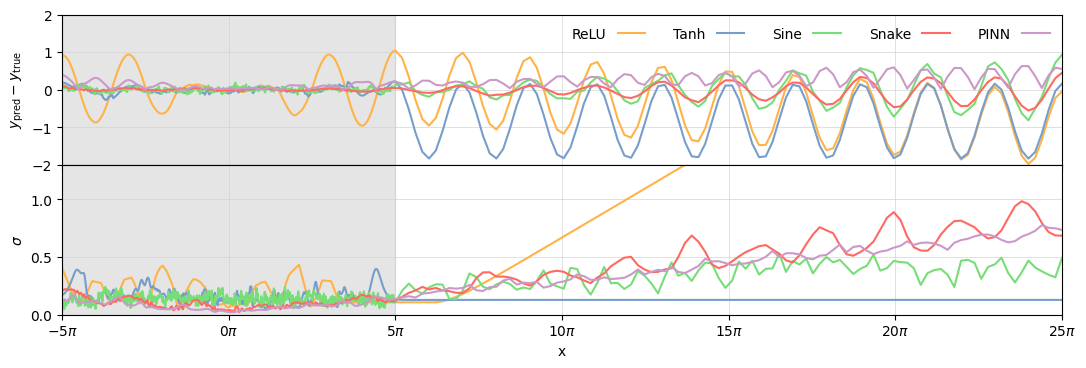

In [50]:
# Define model names and corresponding colors
models = ['ReLU', 'Tanh', 'Sine', 'Snake', 'PINN']
#models = ['Sine', 'Snake', 'PINN']
colors_model = colors[:4] + [colors[4]]


# Analytical solution
x_combined = np.concatenate([train_x_array_snake_ho, test_x_array_ho])
y_analytical = np.cos(x_combined)
x_combined_pinn = np.concatenate([train_x_array_pinn_ho, test_x_array_ho])
y_analytical_pinn = oscillator(d, w0, torch.tensor(x_combined_pinn)).numpy()



# Compute combined losses and absolute differences
combined_losses = {}
abs_diff_means = {}
for model in models[:-1]:  # Exclude PINN for now
    combined_losses[model] = np.cumsum(
        (np.concatenate([mean.loc['Train', model], mean.loc['Test', model]]) - 
         np.concatenate([train_x_array_snake_ho, test_y_array_ho]))**2
    )
    abs_diff_means[model] = np.abs(
        np.concatenate([mean.loc['Train', model], mean.loc['Test', model]]) - y_analytical
    )
    abs_diff_means[model] =  np.concatenate([mean.loc['Train', model], mean.loc['Test', model]]) - y_analytical
    

# For PINN separately
combined_losses['PINN'] = np.cumsum(
    (np.concatenate([mean.loc['Train', 'PINN'], mean.loc['Test', 'PINN']]) - 
     np.concatenate([train_y_array_pinn_ho, test_y_array_ho]))**2
)
abs_diff_means['PINN'] = np.abs(
    np.concatenate([mean.loc['Train', 'PINN'], mean.loc['Test', 'PINN']]) - y_analytical_pinn
)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# Plot absolute difference for each model
for model, color in zip(models, colors_model):
    x_data = x_combined_pinn if model == 'PINN' else x_combined
    alpha = 1 if model in ['ReLU', 'Tanh'] else 1.0  # Apply alpha=0.5 for ReLU and Tanh
    axes[0].plot(x_data, abs_diff_means[model], label=model, color=color, alpha=alpha)

# Plot standard deviation for each model
for model, color in zip(models, colors_model):
    x_data = x_combined_pinn if model == 'PINN' else x_combined
    std_combined = np.concatenate([std.loc['Train', model], std.loc['Test', model]])
    alpha = 1 if model in ['ReLU', 'Tanh'] else 1.0  # Apply alpha=0.5 for ReLU and Tanh
    axes[1].plot(x_data, std_combined, label=model, color=color, alpha=alpha)

for ax in axes:
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_xticks(np.arange(-5, 26, 5) * np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)


# Labels and Legend
axes[0].set_ylabel('$y_{\mathrm{pred}} - y_{\mathrm{true}}$')
axes[0].set_ylim(-2, 2)
axes[0].set_yticks(np.arange(-2, 3, 1))

axes[1].set_xlabel('x')
axes[1].set_ylabel('$\sigma$')
axes[1].set_ylim(0, 1.3)
axes[0].legend(loc='upper right', frameon=False, ncol=5, markerfirst=False)

# Adjust layout and show plot
plt.subplots_adjust(hspace=0, wspace=0) 
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
plt.show()


# Results: Damped Harmonic Osciilator

In [55]:
DHO_train_pred_snake = np.load('E2_Results/DHO_snake_train_pred.npy')
DHO_test_pred_snake = np.load('E2_Results/DHO_snake_test_pred.npy')
DHO_train_pred_pinn = np.load('E2_Results/DHO_pinn_train_pred.npy')
DHO_test_pred_pinn = np.load('E2_Results/DHO_pinn_test_pred.npy')

mean = pd.DataFrame(columns=['Snake', 'PINN'], index=['Train', 'Test'])
std = pd.DataFrame(columns=['Snake', 'PINN'], index=['Train', 'Test'])

mean.loc['Train', 'Snake'] = np.mean(DHO_train_pred_snake, axis=0)
mean.loc['Test', 'Snake'] = np.mean(DHO_test_pred_snake, axis=0)

mean.loc['Train', 'PINN'] = np.mean(DHO_train_pred_pinn, axis=0).squeeze()
mean.loc['Test', 'PINN'] = np.mean(DHO_test_pred_pinn, axis=0).squeeze()

std.loc['Train', 'Snake'] = np.std(DHO_train_pred_snake, axis=0)
std.loc['Test', 'Snake'] = np.std(DHO_test_pred_snake, axis=0)

std.loc['Train', 'PINN'] = np.std(DHO_train_pred_pinn, axis=0).squeeze()
std.loc['Test', 'PINN'] = np.std(DHO_test_pred_pinn, axis=0).squeeze()

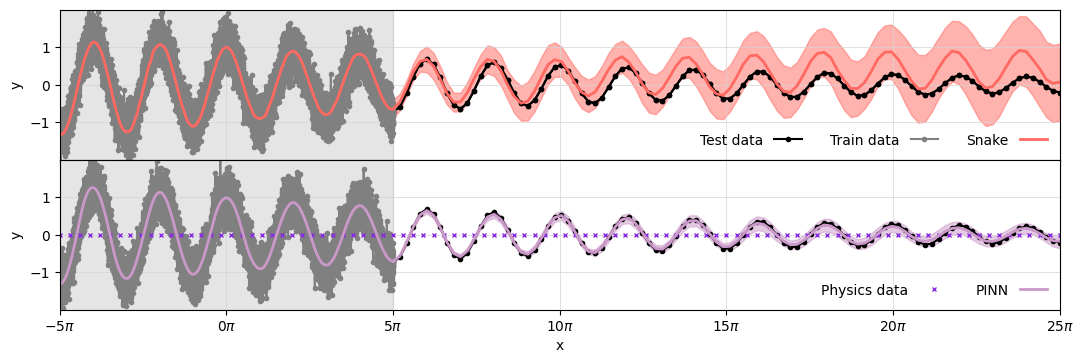

In [ ]:
# PLOT RESULTS
# Create a figure and specify GridSpec
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True) #, gridspec_kw={'height_ratios': [2, 1]})


axes[0].plot(test_x_array_dho, test_y_array_dho, label='Test data', color='black', marker='o', ms=3, ls='-')

# only first four axes
for ax in axes:
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.plot(test_x_array_dho, test_y_array_dho, color='black', marker='o', ms=3, ls='-')


lw = 2
alpha = 0.5

axes[0].plot(train_x_array_snake_dho, train_y_array_snake_dho, label='Train data', color='grey', marker='o', ms=3, ls='-')
axes[0].plot(train_x_array_snake_dho, mean.loc['Train', 'Snake'], label='Snake', color=colors[3], lw=lw)
axes[0].fill_between(train_x_array_snake_dho, mean.loc['Train', 'Snake'] - std.loc['Train', 'Snake'], mean.loc['Train', 'Snake'] + std.loc['Train', 'Snake'], color=colors[3], alpha=alpha)
axes[0].plot(test_x_array_dho, mean.loc['Test', 'Snake'], color=colors[3], ls='-', lw=lw)
axes[0].fill_between(test_x_array_dho, mean.loc['Test', 'Snake'] - std.loc['Test', 'Snake'], mean.loc['Test', 'Snake'] + std.loc['Test', 'Snake'], color=colors[3], alpha=alpha)

axes[1].plot(train_x_array_pinn_dho, train_y_array_pinn_dho, color='grey', marker='o', ms=3, ls='-')
axes[1].plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Physics data', color='blueviolet', marker='x', ms=3, ls='')
axes[1].plot(train_x_array_pinn_dho, mean.loc['Train', 'PINN'], label='PINN', color=colors[4], lw=lw)
axes[1].fill_between(train_x_array_pinn_dho, mean.loc['Train', 'PINN'] - std.loc['Train', 'PINN'], mean.loc['Train', 'PINN'] + std.loc['Train', 'PINN'], color=colors[4], alpha=alpha)
axes[1].plot(test_x_array_dho, mean.loc['Test', 'PINN'], color=colors[4], ls='-', lw=lw)
axes[1].fill_between(test_x_array_dho, mean.loc['Test', 'PINN'] - std.loc['Test', 'PINN'], mean.loc['Test', 'PINN'] + std.loc['Test', 'PINN'], color=colors[4], alpha=alpha)


for ax in axes:
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_ylim(-2, 2.)
    ax.set_ylabel('y')
    ax.set_yticks(np.arange(-1, 2, 1))
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)
    ax.legend(loc='lower right', frameon=False, ncol=3, markerfirst=False)  

axes[1].set_xlabel('x')
plt.xticks(np.arange(-5, 26, 5)*np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])


plt.subplots_adjust(hspace=0, wspace=0) # Remove all spaces between subplots
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
plt.show()


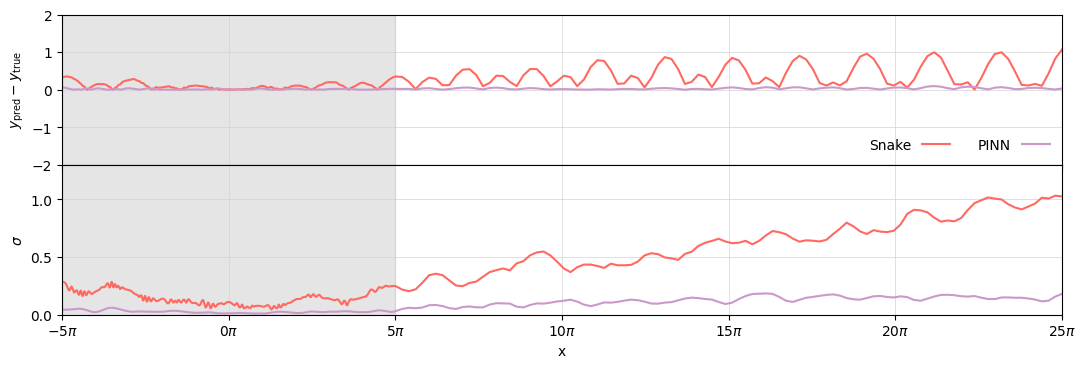

In [ ]:
# Define model names and corresponding colors
models = ['Snake', 'PINN']


# Analytical solution
x_combined = np.concatenate([train_x_array_snake_dho, test_x_array_dho])
y_analytical = np.cos(x_combined)
x_combined_pinn = np.concatenate([train_x_array_pinn_dho, test_x_array_dho])
y_analytical_pinn = oscillator(d, w0, torch.tensor(x_combined_pinn)).numpy()



# Compute combined losses and absolute differences
combined_losses = {}
abs_diff_means = {}

# For Snake separately
abs_diff_means['Snake'] = np.abs(
    np.concatenate([mean.loc['Train', 'Snake'], mean.loc['Test', 'Snake']]) - y_analytical
)

# For PINN separately
abs_diff_means['PINN'] = np.abs(
    np.concatenate([mean.loc['Train', 'PINN'], mean.loc['Test', 'PINN']]) - y_analytical_pinn
)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# Plot absolute difference for each model
axes[0].plot(x_combined, abs_diff_means['Snake'], label='Snake', color=colors[3])
axes[0].plot(x_combined_pinn, abs_diff_means['PINN'], label='PINN', color=colors[4])

# Plot standard deviation for each model
axes[1].plot(x_combined, np.concatenate([std.loc['Train', 'Snake'], std.loc['Test', 'Snake']]), label='Snake', color=colors[3]) 
axes[1].plot(x_combined_pinn, np.concatenate([std.loc['Train', 'PINN'], std.loc['Test', 'PINN']]), label='PINN', color=colors[4])


for ax in axes:
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_xticks(np.arange(-5, 26, 5) * np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)


# Labels and Legend
axes[0].set_ylabel('$y_{\mathrm{pred}} - y_{\mathrm{true}}$')
axes[0].set_ylim(-2, 2)
axes[1].set_xlabel('x')
axes[1].set_ylabel('$\sigma$')
axes[1].set_ylim(0, 1.3)
axes[0].legend(loc='lower right', frameon=False, ncol=5, markerfirst=False)

# Adjust layout and show plot
plt.subplots_adjust(hspace=0, wspace=0) 
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
plt.show()